# RSA

In [1]:
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from fsk.config import layers

In [2]:
rsa_path = Path('/Users/m_vilas/projects/fsk-multimodal/results/rsa')

In [3]:
models = [
    'clip_img', 'clip_txt',  'albef_img', 'albef_txt', 'albef_multi', 'vilt_multi',
    'vit_16', 'vit_32', 'bert_concepts', 'bert_definition', 'gpt_concepts', 'gpt_definition', 
]
hs_types = ['concepts', 'definition']
stream_map = {
    'clip_img': 'image', 'clip_txt': 'text', 'vilt_multi': 'multimodal',
    'albef_img': 'image', 'albef_txt': 'text', 'albef_multi': 'multimodal',
    'bert_concepts': 'text', 'bert_definition': 'text', 'gpt_concepts': 'text',
    'gpt_definition': 'text', 'vit_16': 'image', 'vit_32': 'image'
}
feature_types = [
    'all', 'taxonomic', 'function', 'encyclopaedic', 'visual_perceptual', 'other_perceptual'
]

In [4]:
data = []
for model in models:
    if 'concepts' in model:
        hs_type = 'concepts'
    elif 'definition' in model:
        hs_type = 'definition'
    else:
        hs_type = None
        
    for ft in feature_types:
        if ft == 'all':
            file = rsa_path / f'sem_mcrae_{model}.pkl'
        else:
            file = rsa_path / f'sem_mcrae_{model}_{ft}.pkl'
    
        with open(file, 'rb') as f:
            m_data = pickle.load(f)

        for l_data in m_data:
            layer = l_data[1].split('_')[-1]
            if layer.endswith('c-out'):
                layer = '12'
            data.append([model, layer, stream_map[model], ft, hs_type, l_data[2], l_data[3]])

data = pd.DataFrame(
    data, columns=['model', 'layer', 'stream', 'feature', 'hs_type', 'rsa', 'p_val']
)

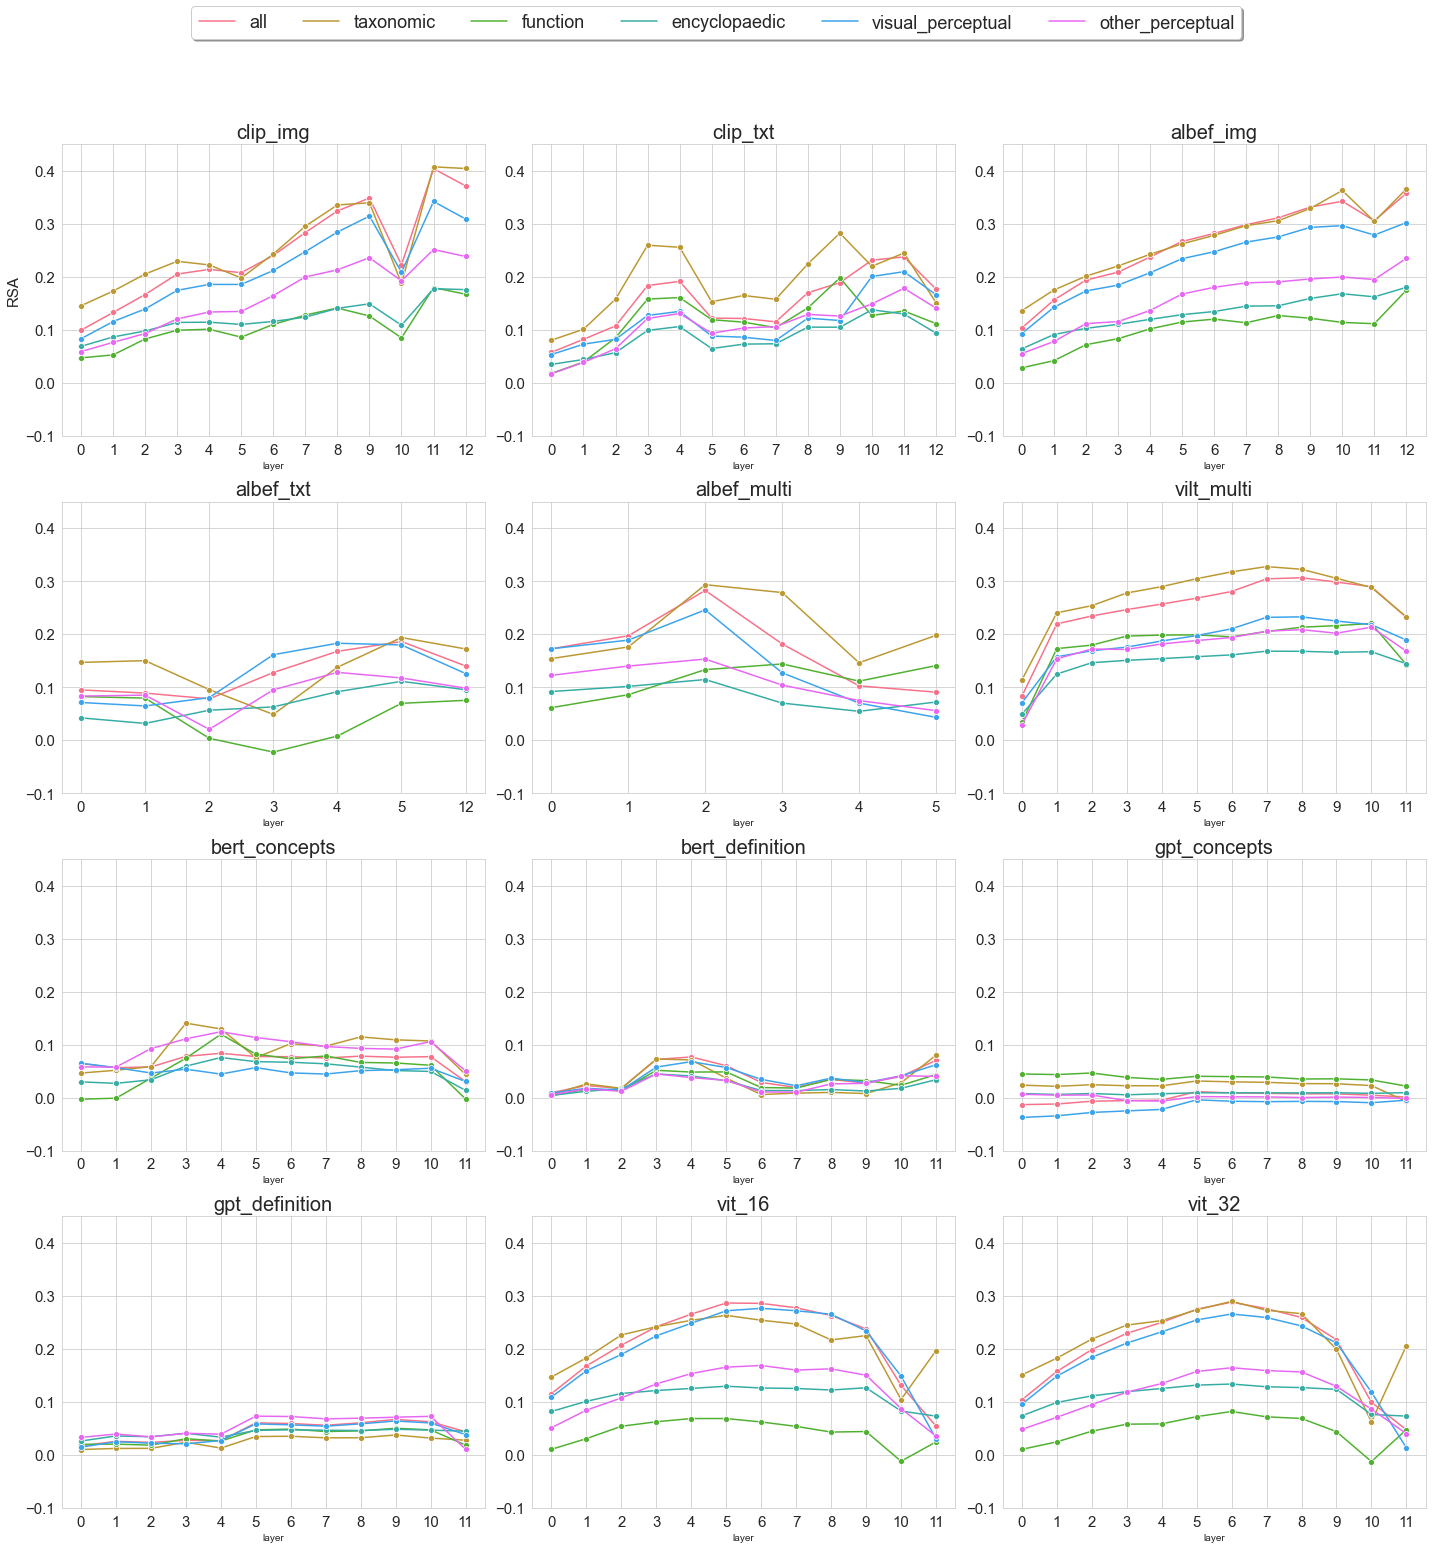

In [7]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,20))
for m, ax in zip(models, axes.flat):
    m_data = data.loc[data['model']==m]
    sns.lineplot(
        x='layer', y='rsa', hue='feature', data=m_data, 
        marker='o', dashes=False, ax=ax, palette="husl"
    )
    ax.set(ylim=(-0.1, 0.45))
    ax.set_title(m, fontsize=20)
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)
    ax.get_legend().remove()
    ax.set(ylabel=None)

axes.flat[0].set_ylabel('RSA', fontsize=15)
lines, labels = axes.flat[0].get_legend_handles_labels()
lgd = fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=6, fancybox=True, shadow=True, fontsize=18)

plt.tight_layout()
plt.show()

__Observations__
- The peak of similarity varies across networks.
    - For image encoders this is at the last layers
    - For albef's multimodal stream this is in the middle layers
- Low similarity for language models
    - And in general, the analysis of the text encoders are unfair, we are not averaging their representations.

__To-Do__
- Repeat text encoders and language models with average.

### Mean similarity across V+L

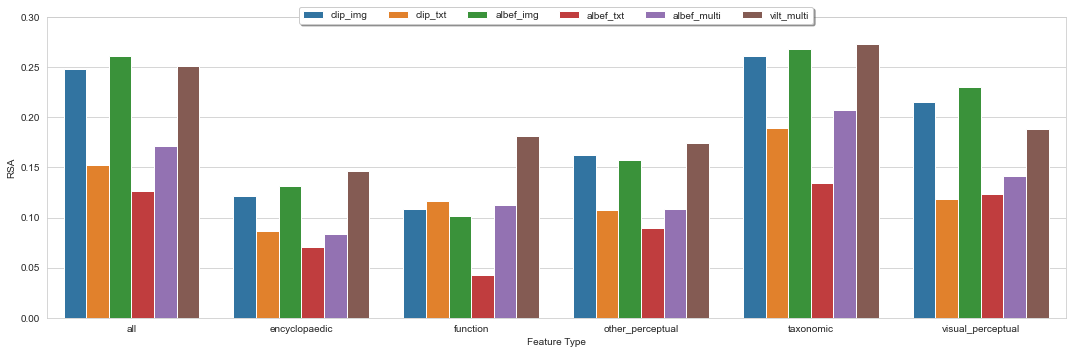

In [11]:
multi_models = ['clip_img', 'clip_txt',  'albef_img', 'albef_txt', 'albef_multi', 'vilt_multi']
multi_data = data.loc[data['model'].isin(multi_models)]
mean_multi_data = multi_data.groupby(['model', 'feature']).mean().reset_index()

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(
    x='feature', y='rsa', hue='model', data=mean_multi_data, 
    hue_order=multi_models
)
ax.set(ylim=(0, 0.3))
ax.set(xlabel='Feature Type', ylabel='RSA')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=6, fancybox=True, shadow=True)
plt.tight_layout()
plt.show()

### Max similarity across V+L

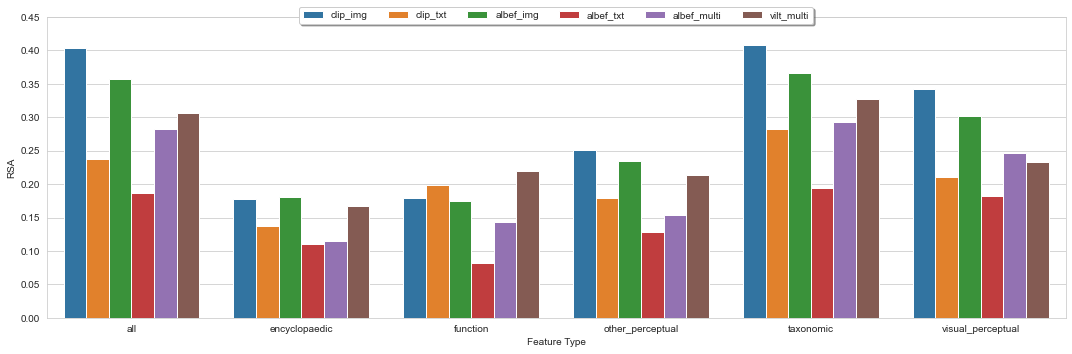

In [13]:
max_multi_data = multi_data.groupby(['model', 'feature']).max().reset_index()

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(
    x='feature', y='rsa', hue='model', data=max_multi_data, 
    hue_order=multi_models
)
ax.set(ylim=(0, 0.45))
ax.set(xlabel='Feature Type', ylabel='RSA')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=6, fancybox=True, shadow=True)
plt.tight_layout()
plt.show()

__Observations__
- Taxonomic and visual perceptual features show the highest similarity
- Again, low performance in text encoders
- Image encoders show high similarity even for type of features that are "non-observable"
    - The high similarity of image encoders could mean that this conceptual distances are groundable in vision
- ViLT and the ALBEF's multimodal stream also show high similarity
   - Although ALBEF multimodal shows this only for taxonomic and visual perceptual


### Comparison of vision streams and models

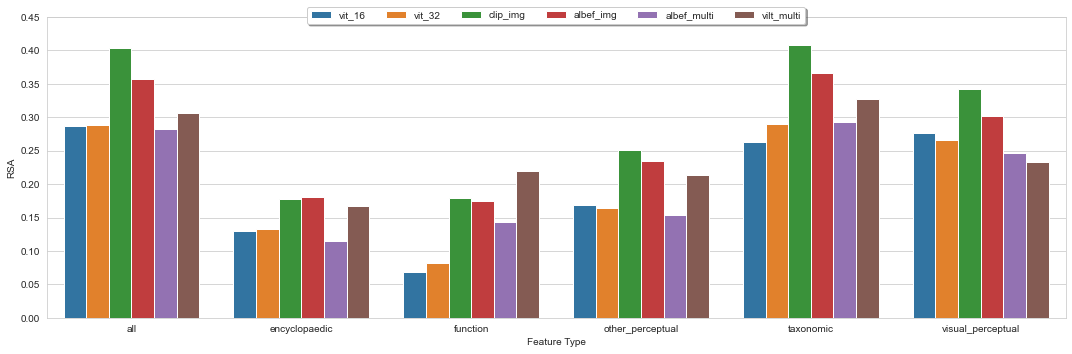

In [18]:
vis_models = [
    'vit_16', 'vit_32', 'clip_img', 'albef_img', 'albef_multi', 'vilt_multi'
]
vis_data = data.loc[data['model'].isin(vis_models)]
max_vis_data = vis_data.groupby(['model', 'feature']).max().reset_index()

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(
    x='feature', y='rsa', hue='model', data=max_vis_data, 
    hue_order=vis_models
)
ax.set(ylim=(0, 0.45))
ax.set(xlabel='Feature Type', ylabel='RSA')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=6, fancybox=True, shadow=True)
plt.tight_layout()
plt.show()

__Observation__
- Multimodal encoders have broadly same similarity with vision models (except for funtion data)
    - And worse performance for visual perceptual data
- Again another evidence that this conceptual distances are confounded with visual properties?

### Comparison of language streams and models

In [24]:
data['model'].unique()

array(['clip_img', 'clip_txt', 'albef_img', 'albef_txt', 'albef_multi',
       'vilt_multi', 'bert_concepts', 'bert_definition', 'gpt_concepts',
       'gpt_definition', 'vit_16', 'vit_32'], dtype=object)

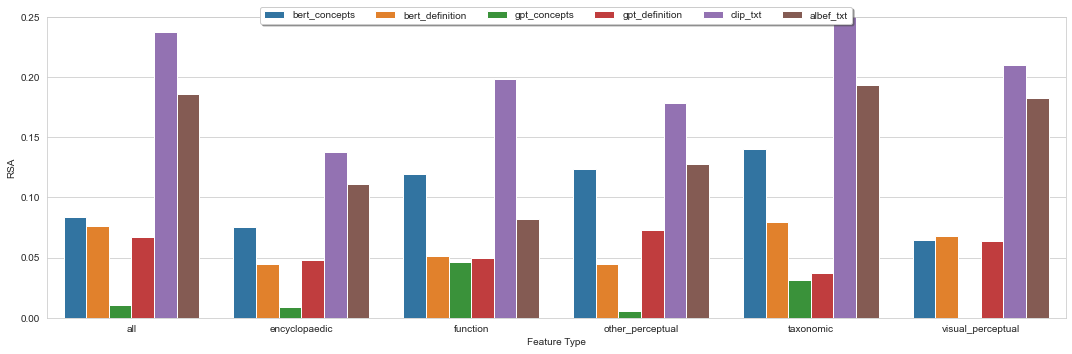

In [28]:
lg_models = [
    'bert_concepts', 'bert_definition', 'gpt_concepts', 'gpt_definition',
    'clip_txt', 'albef_txt'
]
lg_data = data.loc[data['model'].isin(lg_models)]
max_lg_data = lg_data.groupby(['model', 'feature']).max().reset_index()

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(
    x='feature', y='rsa', hue='model', data=max_lg_data, 
    hue_order=lg_models
)
ax.set(ylim=(0, 0.25))
ax.set(xlabel='Feature Type', ylabel='RSA')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=6, fancybox=True, shadow=True)
plt.tight_layout()
plt.show()

__Observations__
- CLIP text stream is the most similar one
    - Followed by ALBEF, except in the function case
- CLIP text is better than ALBEF text in all non-visual features
- Bert Concepts is better, but GPT definition is better

## General To-Do

- Carry out statistical tests for everything